
📉 TI1_tendencias – Comparación entre escenarios


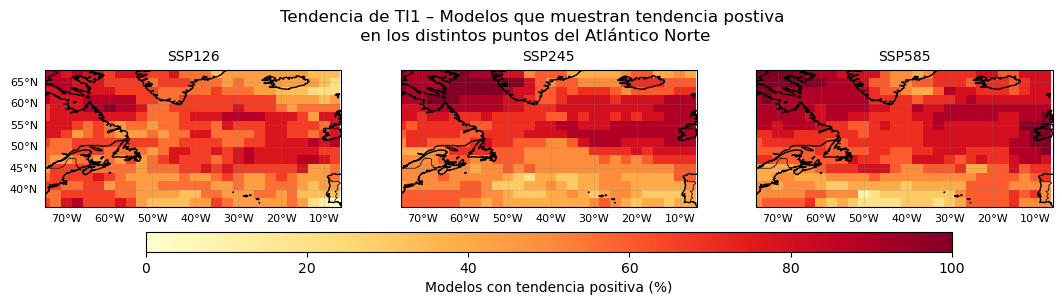

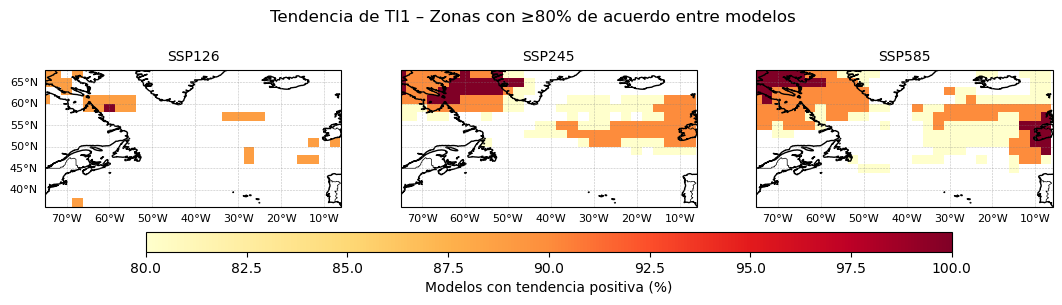

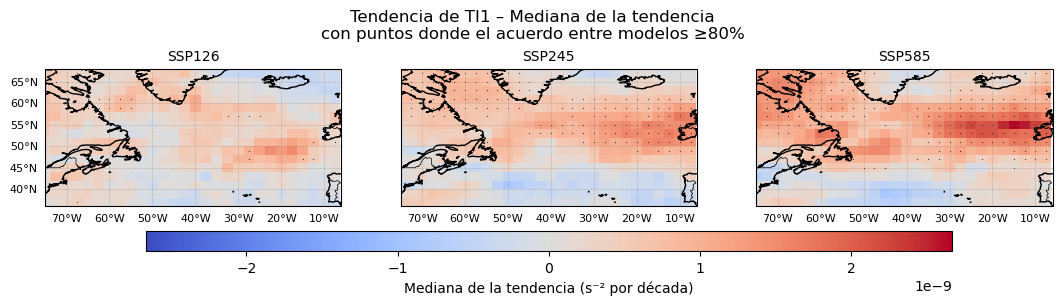


📉 VWS_tendencias – Comparación entre escenarios


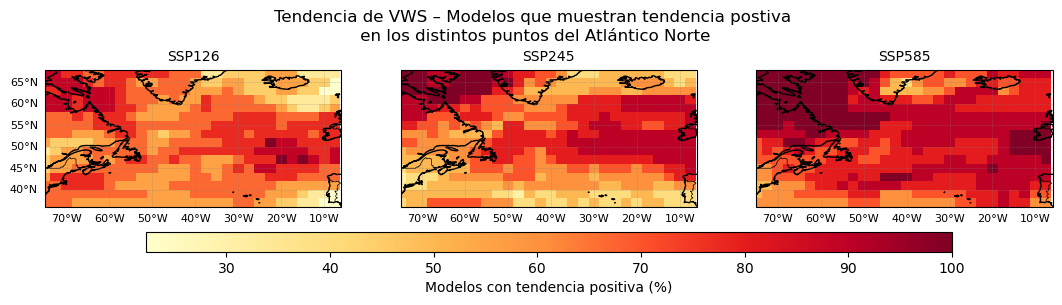

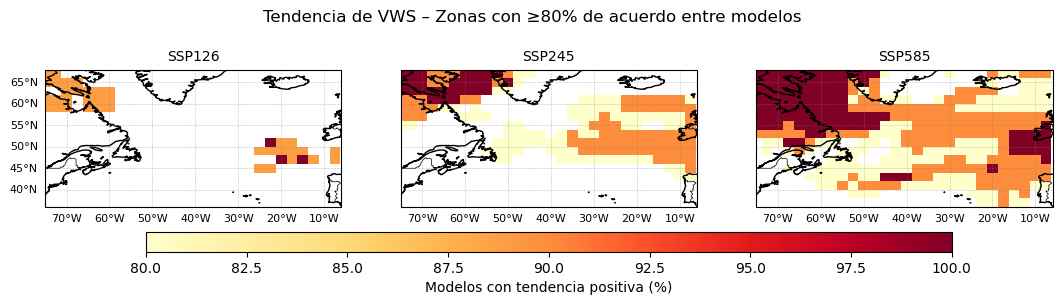

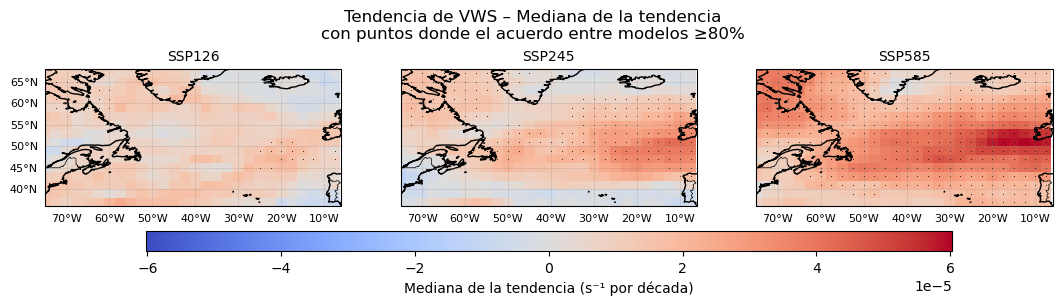


📉 UA_tendencias – Comparación entre escenarios


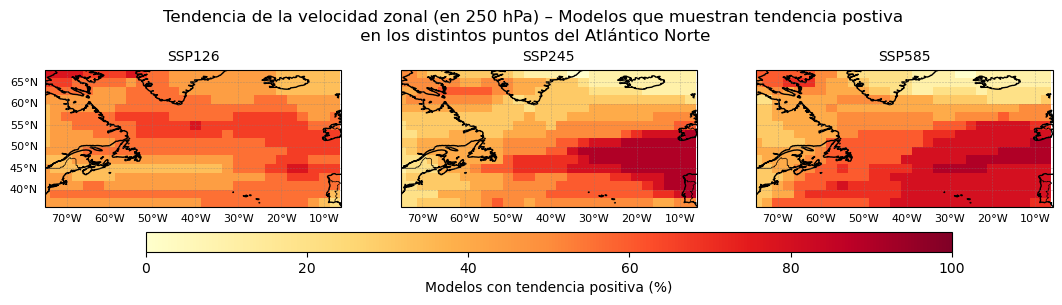

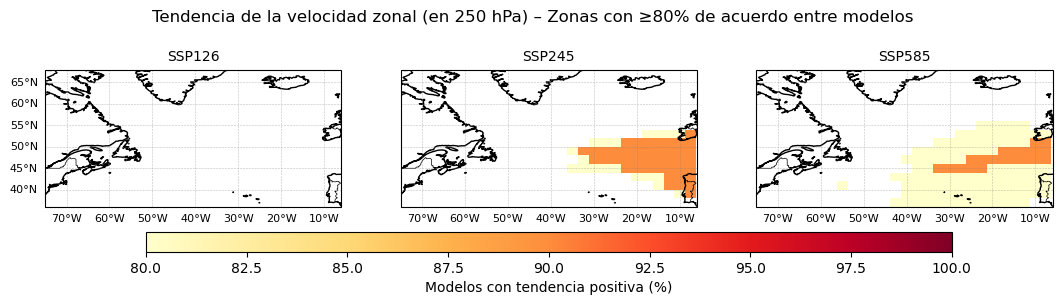

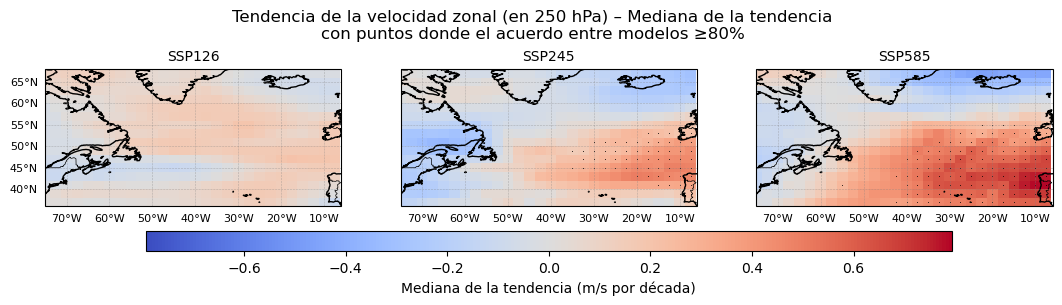


📉 TA_tendencias – Comparación entre escenarios


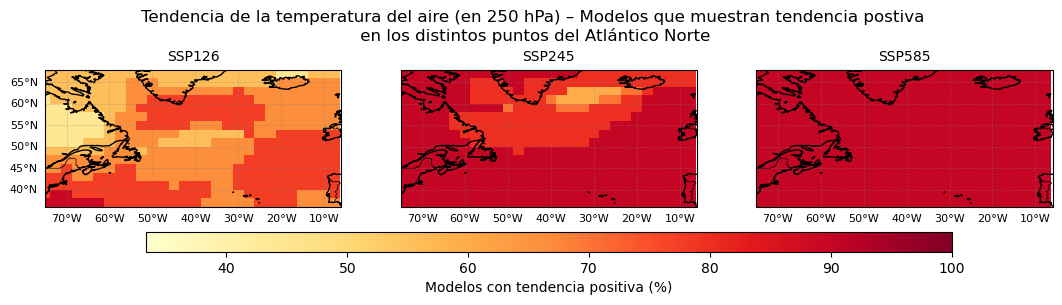

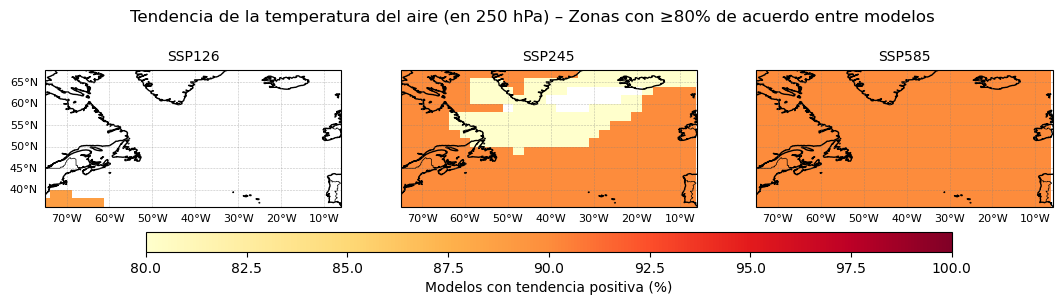

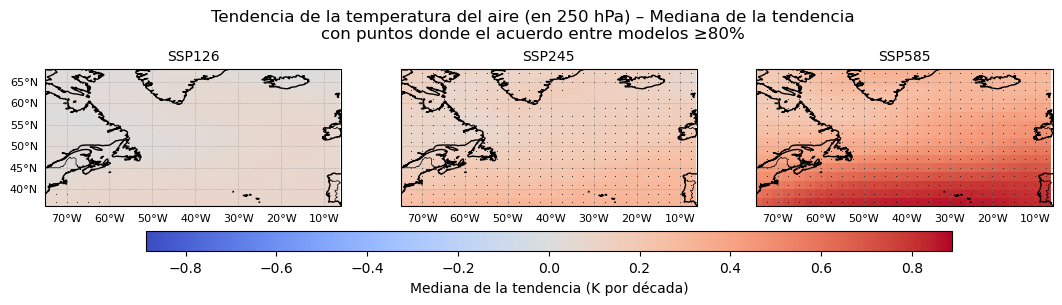


✅ Listo: solo se han guardado FIGURAS (sin NetCDFs).


In [1]:
# CONSENSO INTERMODELO
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# CONFIG
BASE_RESULTADOS = r"C:\Users\jaime\Desktop\Universidad\TFG\Resultados"
ESCENARIOS = ["ssp126","ssp245", "ssp585"]

# Ajusta a los ficheros que realmente tienes
VAR_MEDIA = ["TI1_media", "VWS_media"]          # añade "UA_media" si existe
VAR_TEND  = ["TI1_tendencias",  "VWS_tendencias", "UA_tendencias", "TA_tendencias"]

MAP_EXTENT = [285, 354, 36, 68]
TH_STRONG = 80.0      # ≥80% acuerdo fuerte
ALPHA_SIG = 0.10      # si tienes p-values para tendencias

#  Utilidades
def load_first_var(ds):
    name = list(ds.data_vars.keys())[0]
    return ds[name]

def try_open(path):
    return xr.open_dataset(path) if os.path.exists(path) else None

def plot_pct_map(da_pct, title, fname, extent=MAP_EXTENT, vmin=0, vmax=100, cmap="YlOrRd"):
    fig = plt.figure(figsize=(7, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    da_pct.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
        cbar_kwargs={"label":"%", "orientation":"horizontal", "pad":0.1, "shrink":0.7}
    )
    ax.coastlines(); ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    plt.title(title, fontsize=10)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close(fig)

def plot_bool_stippling(base_field, mask_pos, mask_neg, title, fname, extent=MAP_EXTENT, cmap="coolwarm"):
    fig = plt.figure(figsize=(7, 4))
    ax = plt.axes(projection=ccrs.PlateCarree())

    base_field.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
        cbar_kwargs={"label": base_field.name or "", "orientation":"horizontal", "pad":0.1, "shrink":0.7}
    )

    # Estippling
    yy, xx = xr.broadcast(base_field["lat"], base_field["lon"])
    for msk, marker in [(mask_pos, "."), (mask_neg, "x")]:
        if msk is None:
            continue
        xs = xx.where(msk).values.ravel()
        ys = yy.where(msk).values.ravel()
        ok = np.isfinite(xs) & np.isfinite(ys)
        xs, ys = xs[ok], ys[ok]
        if xs.size > 0:
            ax.scatter(xs, ys, s=1, transform=ccrs.PlateCarree(), marker=marker, color="k", linewidths=0.2)

    ax.coastlines(); ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    plt.title(title, fontsize=10)
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show(fig)
    
def build_tend_paths(base_resultados, esc, varname):
    """
    Devuelve (path_slope, path_pvals, units_label_hint)
    - UA, TI1, VWS: en 'CAT index/por_modelo', nombre en minúsculas del escenario.
    - TA: en 'temperature trends', archivo con escenario en MAYÚSCULAS (según tu ruta).
    """
    esc_low  = esc.lower()
    esc_up   = esc.upper()

    if varname in ("TI1_tendencias", "VWS_tendencias", "UA_tendencias"):
        subdir = os.path.join(base_resultados, esc_low, "CAT index", "por_modelo")
        slope = os.path.join(subdir, f"{varname}_por_modelo_{esc_low}.nc")
        pvals = os.path.join(subdir, f"{varname}_pvalues_{esc_low}.nc")  # puede no existir
    elif varname == "TA_tendencias":
        subdir = os.path.join(base_resultados, esc_low, "temperature trends")
        slope = os.path.join(subdir, f"TA_tendencias_por_modelo_{esc_up}.nc")
        pvals = None  # no nos has indicado p-values para TA
    else:
        slope = pvals = None

    # Pista de unidades por si quieres un fallback; realmente luego leemos del NetCDF
    units_hint = None
    if varname == "TI1_tendencias":
        units_hint = "s⁻²"
    elif varname == "VWS_tendencias":
        units_hint = "s⁻¹"

    return slope, pvals, units_hint

def standardize_spatial_dims(da, level_dim_candidates=("level","lev","plev","pressure"), level_selector=None):
    """
    - Renombra latitude/longitude -> lat/lon si existen.
    - Si hay dims extra de tamaño 1, las elimina (squeeze).
    - Si queda un dim de niveles con tamaño >1:
        - si level_selector es None -> lanza error con pista.
        - si level_selector es dict, hace isel(**level_selector) y drop=True.
    Devuelve un DataArray con dims 2D (lat, lon) o 3D si aún está 'modelo'.
    """
    # Renombrar latitude/longitude
    rename = {}
    if "latitude" in da.dims:
        rename["latitude"] = "lat"
    if "longitude" in da.dims:
        rename["longitude"] = "lon"
    da = da.rename(rename)

    # Quitar dims tamaño 1 (distintas de 'modelo','lat','lon')
    for d in list(da.dims):
        if d not in ("modelo","lat","lon") and da.sizes[d] == 1:
            da = da.isel({d: 0}, drop=True)

    # Si hay una dimensión de niveles con tamaño >1, gestionarla
    level_dims = [d for d in da.dims if d in level_dim_candidates]
    if level_dims:
        d = level_dims[0]
        if da.sizes[d] > 1:
            if level_selector is None or d not in level_selector:
                raise ValueError(
                    f"La variable tiene dimensión de niveles '{d}' con tamaño {da.sizes[d]}.\n"
                    f"Indica qué nivel seleccionar, p.ej. level_selector={{'{d}': 0}} "
                    f"o por valor físico, p.ej. level_selector={{'{d}': 250}} (hPa)."
                )
            sel_val = level_selector[d]

            if d in da.coords:
                coord = da[d]
                # valor objetivo solicitado (p.ej., 250 hPa o 25000 Pa)
                target = float(sel_val)

                units = (coord.attrs.get("units", "") or "").lower()
                # Normaliza a las unidades reales de la coordenada
                if "pa" in units and "hpa" not in units:
                    if target < 2000:      # 250 -> 25000 Pa
                        target = target * 100.0
                elif "hpa" in units:
                    if target > 2000:      # 25000 -> 250 hPa
                        target = target / 100.0

                # Selección robusta por índice más cercano
                vals = np.asarray(coord.values, dtype=np.float64)
                idx = int(np.nanargmin(np.abs(vals - target)))
                da = da.isel({d: idx}, drop=True)
            else:
                # Si no es coordenada etiquetada, asume índice posicional
                da = da.isel({d: int(sel_val)}, drop=True)

    # Comprobación final
    return da
    
# Tendencias – signo (+ significancia si existe)
def consenso_tendencias(slope_da, p_da=None, alpha=ALPHA_SIG, thr_sign=TH_STRONG, thr_sig=50.0):
    signo = xr.apply_ufunc(np.sign, slope_da)
    frac_pos = ((signo > 0).sum('modelo') / slope_da.sizes['modelo'] * 100).rename("frac_pos")
    frac_neg = ((signo < 0).sum('modelo') / slope_da.sizes['modelo'] * 100).rename("frac_neg")

    if p_da is not None:
        sig = (p_da < alpha)
        frac_pos_sig = (((slope_da > 0) & sig).sum('modelo') / slope_da.sizes['modelo'] * 100).rename("frac_pos_sig")
        frac_neg_sig = (((slope_da < 0) & sig).sum('modelo') / slope_da.sizes['modelo'] * 100).rename("frac_neg_sig")
        robusto_pos = ((frac_pos >= thr_sign) & (frac_pos_sig >= thr_sig)).rename("robusto_pos")
        robusto_neg = ((frac_neg >= thr_sign) & (frac_neg_sig >= thr_sig)).rename("robusto_neg")
    else:
        frac_pos_sig = frac_neg_sig = None
        robusto_pos = (frac_pos >= thr_sign).rename("robusto_pos")
        robusto_neg = (frac_neg >= thr_sign).rename("robusto_neg")

    return frac_pos, frac_neg, robusto_pos, robusto_neg, frac_pos_sig, frac_neg_sig

# Diccionario de nombres más legibles para las variables
VAR_LABELS = {
    "TI1_tendencias": "Tendencia de TI1",
    "VWS_tendencias": "Tendencia de VWS",
    "UA_tendencias":  "Tendencia de la velocidad zonal (en 250 hPa)",
    "TA_tendencias":  "Tendencia de la temperatura del aire (en 250 hPa)",
}

# Unidades de la pendiente por variable (tendencias)
SLOPE_UNITS = {
    "TI1_tendencias": "s⁻² por década",
    "VWS_tendencias": "s⁻¹ por década", "TA_tendencias": "K por década", "UA_tendencias": "m/s por década"
}

# Bucle principal
# TENDENCIAS (comparando escenarios)
for varname in VAR_TEND:
    print(f"\n {varname} – Comparación entre escenarios")
    
    # Contenedores para las figuras conjuntas
    frac_pos_list = []
    slope_med_list = []
    rob_pos_list  = []
    rob_neg_list  = []

    # Guardaremos aquí las unidades leídas del primer archivo válido
    units_from_data = None
    
    # Cargar datos de todos los escenarios
    for esc in ESCENARIOS:
        path_tend, path_p, units_hint = build_tend_paths(BASE_RESULTADOS, esc, varname)

        if (path_tend is None) or (not os.path.exists(path_tend)):
            print(f"{varname}: no encontrado -> {path_tend}")
            continue

        ds = xr.open_dataset(path_tend)
        da_slope = load_first_var(ds)
        
        # seleccionar nivel solo para UA/TA, en Pascales (250 hPa = 25000 Pa)
        level_sel = {"plev": 25000} if varname in ("UA_tendencias", "TA_tendencias") else None
        
        da_slope = standardize_spatial_dims(
            da_slope,
            level_dim_candidates=("level","lev","plev","pressure"),
            level_selector=level_sel
        )

        if 'modelo' not in da_slope.dims:
            print(f" {varname}: falta dim 'modelo'.")
            continue

        # Capturar unidades del NetCDF (o usar hint si no vienen)
        if units_from_data is None:
            units_from_data = da_slope.attrs.get("units") or da_slope.attrs.get("unit") or units_hint

        # P-values si existen
        da_p = None
        if path_p and os.path.exists(path_p):
            da_p = load_first_var(xr.open_dataset(path_p))

        # Métricas de consenso de tendencias
        frac_pos, frac_neg, rob_pos, rob_neg, frac_pos_sig, frac_neg_sig = consenso_tendencias(
            da_slope, p_da=da_p, alpha=ALPHA_SIG, thr_sign=TH_STRONG, thr_sig=50.0
        )
        slope_med = da_slope.median('modelo').rename(f"{varname}_mediana_slope")
    
        # Acumular
        frac_pos_list.append(frac_pos.assign_coords(escenario=esc))
        slope_med_list.append(slope_med.assign_coords(escenario=esc))
        rob_pos_list.append(rob_pos.assign_coords(escenario=esc))
        rob_neg_list.append(rob_neg.assign_coords(escenario=esc))
    
    # Concatenar escenarios
    if not frac_pos_list:
        print(f"Ningún escenario con datos válidos para {varname}.")
        continue
    
    frac_pos_all = xr.concat(frac_pos_list, dim='escenario')
    slope_all    = xr.concat(slope_med_list, dim='escenario')
    rob_pos_all  = xr.concat(rob_pos_list,  dim='escenario')
    rob_neg_all  = xr.concat(rob_neg_list,  dim='escenario')

    # Crear figuras conjuntas
    vmin = float(frac_pos_all.min())
    vmax = 100
    
    fig, axes = plt.subplots(1, len(ESCENARIOS), figsize=(13, 4),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    cmap = "YlOrRd"
    
    for i, esc in enumerate(ESCENARIOS):
        ax = axes[i]
        if esc not in frac_pos_all['escenario'].values:
            ax.set_visible(False)
            continue
    
        da = frac_pos_all.sel(escenario=esc)
        im = da.plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
            vmin=vmin, vmax=vmax, add_colorbar=False
        )
        ax.coastlines(); ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_extent(MAP_EXTENT, crs=ccrs.PlateCarree())

        # mostrar etiquetas lat/lon
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0.4, color='gray', alpha=0.5, linestyle='--'
        )
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}
        from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.left_labels = (i == 0)  # solo el primer panel
        gl.bottom_labels = True    # longitudes en todos
        
        ax.set_title(f"{esc.upper()}", fontsize=10)
    
    # Barra de color compartida
    cbar = fig.colorbar(
        im, ax=axes.ravel().tolist(), orientation='horizontal',
        fraction=0.15, pad=0.08, shrink=0.8, aspect=40
    )
    cbar.set_label("Modelos con tendencia positiva (%)")

    titulo = VAR_LABELS.get(varname, varname)
    plt.suptitle(f"{titulo} – Modelos que muestran tendencia postiva\n en los distintos puntos del Atlántico Norte", fontsize=12, y=0.78)
    os.makedirs(os.path.join(BASE_RESULTADOS, "figs_comparadas"), exist_ok=True)
    plt.savefig(os.path.join(BASE_RESULTADOS, "figs_comparadas", f"{varname}_frac_pos_todos.png"),
                dpi=300, bbox_inches="tight")
    plt.show(fig)

    # Nueva figura: solo regiones con ≥80% de acuerdo
    vmin_strong = 80
    vmax_strong = 100
    cmap = "YlOrRd"

    fig, axes = plt.subplots(1, len(ESCENARIOS), figsize=(13, 4),
                             subplot_kw={'projection': ccrs.PlateCarree()})

    for i, esc in enumerate(ESCENARIOS):
        ax = axes[i]
        if esc not in frac_pos_all['escenario'].values:
            ax.set_visible(False)
            continue

        # Selecciona el escenario y enmascara valores <80 %
        da = frac_pos_all.sel(escenario=esc)
        da_masked = da.where(da >= vmin_strong)

        im = da_masked.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            vmin=vmin_strong, vmax=vmax_strong,
            add_colorbar=False
        )

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_extent(MAP_EXTENT, crs=ccrs.PlateCarree())
        
        # mostrar etiquetas lat/lon
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0.4, color='gray', alpha=0.5, linestyle='--'
        )
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}
        from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.left_labels = (i == 0)  # solo el primer panel
        gl.bottom_labels = True    # longitudes en todos
        
        ax.set_title(f"{esc.upper()}", fontsize=10)

    # Barra de color compartida
    cbar = fig.colorbar(
        im, ax=axes.ravel().tolist(), orientation='horizontal',
        fraction=0.15, pad=0.08, shrink=0.8, aspect=40
    )
    cbar.set_label("Modelos con tendencia positiva (%)")

    titulo = VAR_LABELS.get(varname, varname)
    plt.suptitle(f"{titulo} – Zonas con ≥{vmin_strong}% de acuerdo entre modelos", fontsize=12, y=0.78)
    os.makedirs(os.path.join(BASE_RESULTADOS, "figs_comparadas"), exist_ok=True)
    plt.savefig(os.path.join(BASE_RESULTADOS, "figs_comparadas",
                             f"{varname}_frac_pos_{vmin_strong}a{vmax_strong}.png"),
                dpi=300, bbox_inches="tight")
    plt.show(fig)
    
    # Figura con mediana del slope + estippling robusto
    # Límites reales del ensemble
    vmin_slope = float(slope_all.min())
    vmax_slope = float(slope_all.max())
    
    # Límite simétrico alrededor de 0
    import matplotlib.colors as mcolors
    lim = max(abs(vmin_slope), abs(vmax_slope))
    
    # Normalización centrada en 0
    norm_slope = mcolors.TwoSlopeNorm(vcenter=0, vmin=-lim, vmax=lim)
    
    cmap_slope = "coolwarm"
    
    fig, axes = plt.subplots(
        1, len(ESCENARIOS), figsize=(13, 4),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    
    for i, esc in enumerate(ESCENARIOS):
        ax = axes[i]
        if esc not in slope_all['escenario'].values:
            ax.set_visible(False)
            continue
    
        base_field = slope_all.sel(escenario=esc)
    
        # norm_slope en vez de vmin/vmax
        im = base_field.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmap_slope,
            norm=norm_slope,
            add_colorbar=False
        )
    
        # Estippling
        msk_pos = rob_pos_all.sel(escenario=esc)
        yy, xx = xr.broadcast(base_field["lat"], base_field["lon"])
        xs = xx.where(msk_pos).values.ravel()
        ys = yy.where(msk_pos).values.ravel()
        ok = np.isfinite(xs) & np.isfinite(ys)
        if np.any(ok):
            ax.scatter(xs[ok], ys[ok], s=1, transform=ccrs.PlateCarree(),
                       marker='.', color='k', linewidths=0.2)
    
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.set_extent(MAP_EXTENT, crs=ccrs.PlateCarree())
    
        gl = ax.gridlines(
            crs=ccrs.PlateCarree(), draw_labels=True,
            linewidth=0.4, color='gray', alpha=0.5, linestyle='--'
        )
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {"size": 8}
        gl.ylabel_style = {"size": 8}
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.left_labels = (i == 0)
        gl.bottom_labels = True
    
        ax.set_title(f"{esc.upper()}", fontsize=10)
    
    # COLORBAR centrado en 0
    from matplotlib.cm import ScalarMappable
    
    sm = ScalarMappable(norm=norm_slope, cmap=cmap_slope)
    sm.set_array([])   # necesario para el colorbar
    
    cbar = fig.colorbar(
        sm, ax=axes.ravel().tolist(),
        orientation='horizontal',
        fraction=0.15, pad=0.08, shrink=0.8, aspect=40
    )
    
    cbar.set_label(
        f"Mediana de la tendencia ({SLOPE_UNITS.get(varname, '')})"
        if SLOPE_UNITS.get(varname) else "Mediana de la tendencia"
    )
    
    titulo = VAR_LABELS.get(varname, varname)
    plt.suptitle(
        f"{titulo} – Mediana de la tendencia\n"
        f"con puntos donde el acuerdo entre modelos ≥{vmin_strong}%",
        fontsize=12, y=0.78
    )
    
    plt.savefig(
        os.path.join(BASE_RESULTADOS, "figs_comparadas",
                     f"{varname}_slope_robusto_todos.png"),
        dpi=300, bbox_inches="tight"
    )
    plt.show(fig)
print("\nListo: solo se han guardado FIGURAS (sin NetCDFs).")